# Modeling Uncertainty in Observations

Have you ever waited on someone to call you to let you know something happened? Or have you wondered how future Martian explorers will be able to reason about timelines when it takes minutes for messages from Mission Control to reach them? Simple Temporal Networks with Uncertainty give us the tools for modeling ambiguity, but they still assume an instantaneous relationship between when events occur and when the agent observes them. What if we remove that assumption? What if the agent doesn't learn about events until much later? Or maybe never? In that case, we need a new kind of controllability - _Delay Controllability_.

In this lesson, we will explore how to model STNUs when there are delays in communication.

Run the cell below to set up the notebook.

In [3]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
from render import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## An Intuition for Observation Delay

Let's look at a scenario where observation delay factors into our decision making.

> Picture yourself doing chores around the house. You have a fancy new clothes dryer that senses how dry your clothes are and will keep spinning until they're completely dry. When it's done, it will beep until you open the door because it doesn't want your clothes to get wrinkled. It takes a minute for you to throw a load of wet laundry into the dryer and then head back to the kitchen to keep cleaning. You know the machine will take between 40 and 60 minutes to dry your clothes. You're listening to music with your headphones on, so you may not immediately hear when the wash is done. You want to make sure that your dry clothes haven't been sitting for more than 30 minutes before you fold them, but you want to wait at least 10 minutes to let them cool off a little first.

We can naively write the following STNU, letting $L$ represent loading the dryer, $D$ represent the dryer cycle, $K$ represent cleaning the kitchen, and $F$ represent folding.

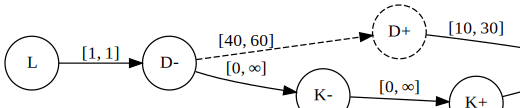

In [4]:
stn = nx.DiGraph()
stn.add_edge('L', 'D-', stc=[1, 1])
stn.add_edge('D-', 'D+', ctg=[40, 60])
stn.add_edge('D-', 'K-', stc=[0, np.inf])
stn.add_edge('K-', 'K+', stc=[0, np.inf])
stn.add_edge('K+', 'F', stc=[0, np.inf])
stn.add_edge('D+', 'F', stc=[10, 30])
display_stn(stn)

Let's look at a scenario where observation delay factors into our decision making.

> At 8am every morning, Sam brews a large pot of coffee for the office. The machine Sam uses is old and temperamental, so it can take anywhere between 15 and 30 minutes before the coffee is ready. The coffee machine is several rooms away from the office, meaning workers in the office have no immediate way of knowing when the coffee is ready. Every morning, Sam sends an email to the group to let them know the coffee is ready, but only after he finishes his first cup. Drinking a cup of coffee takes Sam somewhere between 5 and 15 minutes. Alex waits in the office and wants to get coffee after it has cooled a bit; she finds the coffee temperature to be optimal between 20 and 30 minutes after the coffee is ready. It takes Alex 5 minutes to finish her coffee, and once she is done, she goes to a client meeting that starts at 9am.

We can naively build the following STNU, letting $A$ represent when Sam starts making coffee, $B$ represent when the coffee finishes brewing, $C$ represent Alex getting coffee, and $D$ represent when Alex gets to the meeting.

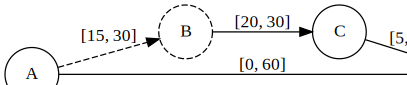

In [5]:
stn = nx.DiGraph()
stn.add_edge('A', 'B', ctg=[15, 30])
stn.add_edge('B', 'C', stc=[20, 30])
stn.add_edge('C', 'D', stc=[5, 5])
stn.add_edge('A', 'D', stc=[0, 60])
display_stn(stn)

Something is missing. Remember, Sam does not send the email until he finishes his coffee, which takes between 5 and 10 minutes. In effect, while $B$ may occur in $[15, 30]$, we won't learn about $B$ for another $[5, 15]$ after it finishes. But Alex needs to factor this time into deciding when to get coffee, $C$.

Let's add a new decorator to the STNU to indicate the presence of observation delay on contingent events. We'll call it a delay function, $\gamma(e_c)$, where $e_c$ is a contingent event. For this implementation, we'll let $\gamma(e_c)$ return set bounded range, $[l, u]$, just like the other constraints in an STNU. In effect, $\gamma(e_c) = [l, u]$ indicates that we will not learn that $e_c$ has resolved for an additional $[l, u]$ units of time.

(Unfortunately, we're at the limit of the kind of graphs that we can easily generate with the `graphviz` package. We'll be inserting hand-drawn STNUs from here on out.)

In [ ]:
# insert img of STNU with gamma

It is important to note that observations of contingent events with $\gamma$ functions provide less information than observations of other events. With uncertainty in both the contingent event and our delayed observation of it, we lose the guarantee that we know for certain when an event actually occured.

Consider event $B$, Alex learning the coffee is brewed, in the STNU above. There is a range of outcomes that could lead to an observation of $B$ at 25. For instance, the coffee could have finished brewing in 15 minutes and Sam could have waited 10 minutes to email Alex. Or the coffee could have finished in 20 minutes and Sam could have waited 5 minutes to email Alex. In fact, any combination of $B + \gamma(B) = 25$ where $B \in [15, 30], \gamma(B) \in [5, 15]$ is valid. By our formulation, we _do not know_ which combination led to our observation at 25.

Thus, communication in this scenario does not offer certainty about when to act.

Given that Sam starts brewing at 8am, if Alex receives the email any time before 8:40am, it is simple for her to devise an execution policy based on the fact that the email arrives between 5 and 15 minutes after the coffee is brewed. If she waits 15 minutes after receiving the email, she is guaranteed to get her coffee between 20 and 30 minutes after it is brewed, at which time the coffee will have cooled to her liking. The challenge for Alex comes when the email arrives after 8:40am. In this situation, waiting 15 minutes will make Alex late for her 9am meeting. To address the ambiguity around how Alex should act when the email arrives after 8:40am, we reason about the range of possible values associated with the time that it takes to brew coffee and the time for the email to be sent. Specifically, Alex knows that it takes at most 15 minutes for Sam to drink coffee and for the email to be sent. If an email has not arrived by 8:40am, the coffee must have taken at least 25 minutes to brew, finishing at 8:25am (8:25am + 15 minute delay = 8:40am). Coffee brewing also has an upper bound of 30 minutes, so it could have finished 10 minutes ago at 8:30am (8:30am + 10 minute delay = 8:40am). As a result, if Alex gets coffee at 8:55am, she has a guarantee that the coffee has been sitting out between 25 and 30 minutes (i.e., [8:55am - 8:30am, 8:55am - 8:25am] = [25, 30]). This is within Alex’s 20 to 30 minute window for waiting for the coffee to 4Uncertain Communication in Temporal Networks cool, while still giving her enough time drink her coffee and attend her meeting on time. Delay controllability, and more specifically, variable-delay controllability, formalizing checking for controllability with uncertain communications.